In [240]:
import random                  
import math
import numpy as np
from matplotlib import pyplot as plt

In [475]:
populations = np.array([20.0, 100.0, 300.0, 100.0])
predation_table = np.zeros([4, 4])
predation_table[0, 1] = 0.0015
predation_table[1, 2] = 0.003
predation_table[0, 2] = 0.0005
predation_table[2, 3] = 0.002
predation_table[3, 0] = 0.001
predation_table[3, 1] = 0.001
predation_table -= predation_table.T

print(predation_table)

reproduction_rates = np.array([-0.02, 0.03, 0, 0])

[[ 0.      0.0015  0.0005 -0.001 ]
 [-0.0015  0.      0.003  -0.001 ]
 [-0.0005 -0.003   0.      0.002 ]
 [ 0.001   0.001  -0.002   0.    ]]


In [476]:
def update(populations, predation_table, reproduction_rates, dt=0.02):
    new_populations = populations
    for i in range(0, populations.shape[0]):
        growth_factor = populations[i]*(reproduction_rates[i] + np.sum(populations*predation_table[i, :]))
        #growth_factor += populations[i]*random.uniform(0, 1)*0.01
        new_populations[i] += growth_factor*dt
    return new_populations

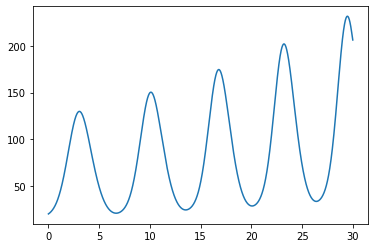

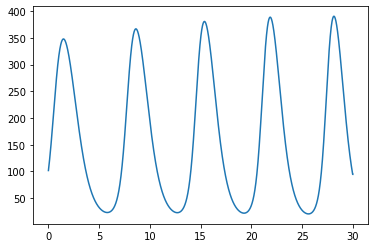

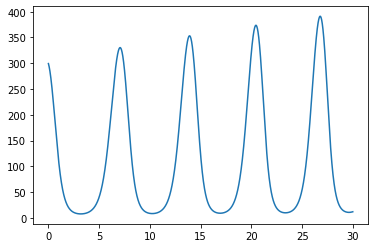

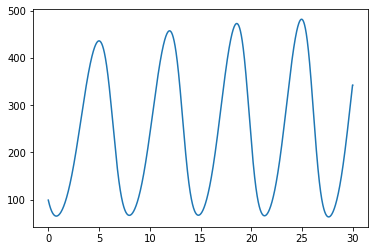

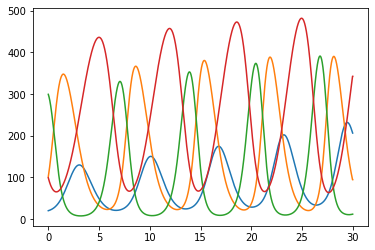

In [480]:
n_iter = 3000;
population_evolution = np.array([populations]);
for i in range(1, n_iter):
    last_populations = population_evolution[-1, :]
    new_populations = update(last_populations, predation_table, reproduction_rates)
    population_evolution = np.append(population_evolution, [new_populations], axis=0)

xs = [0.01*x for x in range(0, n_iter)]
plt.plot(xs, population_evolution[:, 0])
plt.show()
plt.plot(xs, population_evolution[:, 1])
plt.show()
plt.plot(xs, population_evolution[:, 2])
plt.show()
plt.plot(xs, population_evolution[:, 3])
plt.show()
plt.plot(xs, population_evolution)

# What I tried

- Modelling populations as a vector and the predation rules as a matrix, applying matrix multiplication I would then get the population after one cycle, however this is too simplistic, as population growth does not depend only on the population of the other species, but also its own
- Next I tried generalizing the [Lotka-Volterra](https://services.math.duke.edu/education/webfeats/Word2HTML/Predator.html) model for prey-predator dynamics, however this didn't work out as I thought, since it resulted only in infrequent spikes of populations, which wouldn't be interesting for the piece
- Then I tried removing the reproduction rates (so the only cause of population growth is predation), and I started getting results which looked more interesting
- Finally I figured out keeping slight reproduction rates was useful for balancing and finding a good equilibrium
- Below follows a version where I also try to model how the sound masses would move - however when I tried to implement some type of accelleration towards/away from prey/predator, the positions of the individual species just diverged. Even when I tried to implement some sort of attraction to 0, to keep things in bounds, things were not very tame, so for the purpose of keeping some remotely musical structure, I had to simplify the model so it doesn't really simulate how the species would move in space, but rather it reacts to changes in populations and tries to get closer/farther away from the initial (mean) positions of the given prey/predator. The advantage of this is that we get a periodic pattern which reflects the changes in intensity that occur.

In [528]:
populations = np.array([20.0, 100.0, 300.0, 100.0])
positions = np.linspace(-1, 1, 4)
predation_table = np.zeros([4, 4])
predation_table[0, 1] = 0.0015
predation_table[1, 2] = 0.003
predation_table[0, 2] = 0.0005
predation_table[2, 3] = 0.002
predation_table[3, 0] = 0.001
predation_table[3, 1] = 0.001
predation_table -= predation_table.T

print(predation_table)

reproduction_rates = np.array([-0.02, 0.03, 0, 0])

[[ 0.      0.0015  0.0005 -0.001 ]
 [-0.0015  0.      0.003  -0.001 ]
 [-0.0005 -0.003   0.      0.002 ]
 [ 0.001   0.001  -0.002   0.    ]]


In [546]:
def update(populations, positions, predation_table, reproduction_rates, dt=0.02):
    new_populations = populations
    new_positions = np.zeros(positions.shape)
    for i in range(0, populations.shape[0]):
        growth_factor = populations[i]*(reproduction_rates[i] + np.sum(populations*predation_table[i, :]))
        #growth_factor += populations[i]*random.uniform(0, 1)*0.01
        new_populations[i] += growth_factor*dt
        
        accelleration = np.sum(populations*(positions - positions[i])*predation_table[i, :])
        new_positions[i] = positions[i] + accelleration
    return (new_populations, new_positions)

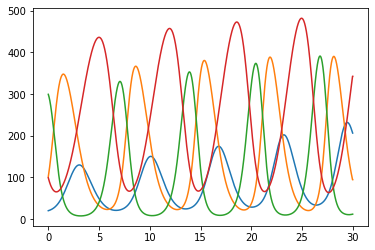

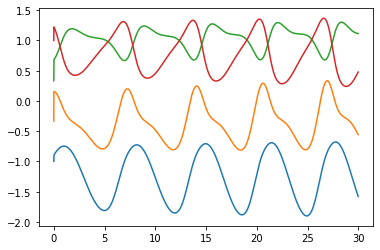

In [547]:
n_iter = 3000;
population_evolution = np.array([populations]);
positions_evolution = np.array([positions])
for i in range(1, n_iter):
    last_populations = population_evolution[-1, :]
    last_positions = positions_evolution[-1, :]
    (new_populations, new_positions) = update(last_populations, positions, predation_table, reproduction_rates)
    population_evolution = np.append(population_evolution, [new_populations], axis=0)
    positions_evolution = np.append(positions_evolution, [new_positions], axis=0)

xs = [0.01*x for x in range(0, n_iter)]
#plt.plot(xs, population_evolution[:, 0])
#plt.show()
#plt.plot(xs, population_evolution[:, 1])
#plt.show()
#plt.plot(xs, population_evolution[:, 2])
#plt.show()
#plt.plot(xs, population_evolution[:, 3])
#plt.show()
plt.plot(xs, population_evolution)
plt.show()
plt.plot(xs, positions_evolution)
plt.show()


In [504]:
predation_table

array([[ 0.    ,  0.0015,  0.0005, -0.001 ],
       [-0.0015,  0.    ,  0.003 , -0.001 ],
       [-0.0005, -0.003 ,  0.    ,  0.002 ],
       [ 0.001 ,  0.001 , -0.002 ,  0.    ]])